***

# HCI Week 5 - Spectral Differential Imaging

*Matthew Kenworthy // Leiden Observatory*
***

Today in [*Questions 5.1*](#part1) *- 5.3* you will determine the spectral type of a faint companion by comparing the flux of the primary star to the flux of the secondary companion. Thereafter in [*Questions 5.4*](#part2) *- 5.8* you will be deriving the Methane Spectral Index (MSI), which is a measure of the amount of methane detected in the companion. 

The data is kindly provided by Dr. Beth Biller from the Royal Observatory Edinburgh.

<div class="alert alert-block alert-info">
<b>Tip:</b> As always, read through the functions defined in the block below, as they may help with the exercises.</div>

Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline


def box(c,x,y,trim=0):
    """box - chop out a square box from an array c from center (x,y) with width trim"""
    c2 = np.copy(c)
    (nx,ny) = c.shape
    dx = x - trim
    dy = y - trim
    c2 = c[dy:dy+2*trim,dx:dx+2*trim]
    
    return(c2)

def circle_mask(im, xc, yc, rcirc):
    """circle_mask - function that takes the input 2D array 'im' that evaluates the equation 
            (x-x_c)^2 + (y-y_c)^2 < r^2 with circle center coordinates (x_c, y_c) and a radius 'r'
            as input parameters and return a mask array with the same shape as 'im'."""
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    return ( (r < rcirc))

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)


# read in the two data cubes
f1, head = fits.getdata('cube_f1.fits', header=True)
f3a, head = fits.getdata('cube_f3a.fits', header=True)

## Details of the observations

The SDI camera uses two narrowband filters, called `F1` and `F3a`, that measure flux in and out of the methane absorption feature in the H band (1.6 microns).

There are two image cubes, one in the `F1` band and the other in the `F3a` band, each containing four separate images.

`F1` is at 1.575 microns, and `F3a` is at 1.625 microns, with a full width of 0.025 microns. Both filters can be assumed to be 100% transmission inside the filter bandpass and 0% transmission outside the bandpass.

The **Methane Spectral Index (MSI)** is defined as:

$$\text{MSI} = \frac{\text{Mean flux in band F1}}{\text{Mean flux in band F3a}} $$

The primary star is called SCR 1845-6357 has a spectral type M8.5, and the secondary companion appears at a separation of 1.170 arcsec from the primary and at a position angle of 170.20 degrees.

The plate scale of the SDI camera is $0.01725\pm0.00025$ arcsec/pixel.


<div class="alert alert-block alert-success">
<b>Example 5.1:</b> Let us take a look at the observations in the spectral band `F1` </b>
</div>  

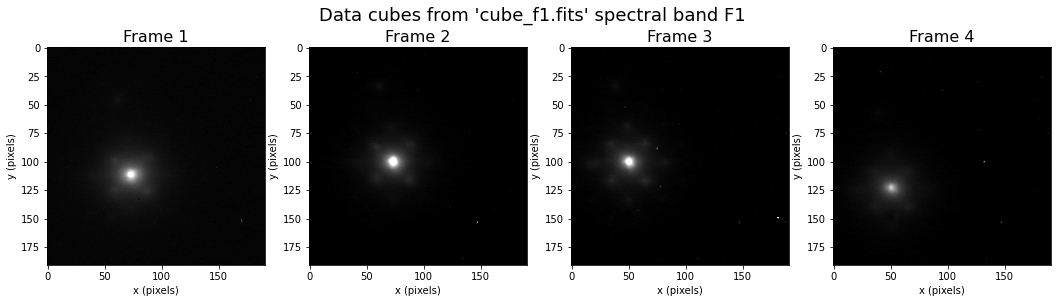

In [2]:
fig, axs = plt.subplots(1,4, figsize=(18,4))   
for idx_a,ax in enumerate(axs.flatten()):
    ax.imshow(f1[idx_a], vmin=0., vmax=1000., cmap='gray')
    ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
    ax.set_title('Frame {}'.format(idx_a+1), fontsize=16) 
fig.suptitle("Data cubes from 'cube_f1.fits' spectral band F1", fontsize=18, y=1.02)

plt.show()


<div class="alert alert-block alert-success">
<b>Example 5.2:</b> We can also use the function <code>box()</code> to make a zoom-in of specific regions in the spectral bands <code>F1</code> and <code>F3a</code>. Look at the several observations and see from the code that the <code>.fits</code> files contain 4 cubes.
</div>  

In [3]:
%run ../week_1/interactive

spectra = [f1,f3a]
title1 = ["cube_f1.fits","cube_f3a.fits"]
title2 = ["F1","F3"]

def interactive_plot_cube(x,y,size,cube):  
    fig, axs = plt.subplots(1,4, figsize=(18,4))   
    
    name1 = title1[cube]
    name2 = title2[cube]
    for idx_a,ax in enumerate(axs.flatten()):
        ax.imshow(box(spectra[cube][idx_a],x,y,size), vmin=0., vmax=1000., cmap='gray')
        ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
        ax.set_title('Frame {}'.format(idx_a+1), fontsize=18)      
    fig.suptitle("Data cubes from '{}' spectral band {}".format(name1,name2), fontsize=18, y=1.02)
    return    

interactive_plot = interactive(interactive_plot_cube, x=(70,130), y=(70,130), size=(40,70,10), cube=widgets.Dropdown( options=[('F1', 0), ('F3a', 1)],value=0, description='Spectral band:'))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot


interactive(children=(IntSlider(value=100, description='x', max=130, min=70), IntSlider(value=100, description…

<Figure size 432x288 with 0 Axes>

## Measuring MSI from a Spectral Library
<a id='part1'></a>

Spectra of M, L and T stars in the near-infrared (M and L Dwarf Near-Infrared Standards) have been collected at the SpeX Prism Spectral Libraries, and these spectra are stored in text files containing the name `spex-prism` with this notebook. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.1</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Create a Figure containing the spectrum of the primary star that reveals the spectral bands**

1. **Given the spectral type of the primary star, find a spectrum with the same spectral type by looking at the names of the `spex-prism` files in the current directory. 
Open it using `spec_star = ascii.read('<spectrum_filename>.txt')` and plot it using `ax.errorbar()`.**


<div class="alert alert-block alert-info">
<b>Tip 1:</b> Look at the first few lines of each of the spectra files... </div>

2. **Plot the normalised flux versus the wavelength. The wavelength goes from 1.0 to 2.0 microns and the normalised flux from 0.0 to 1.0.**
* **Add a red rectangle to show the wavelength range of the F1 filter and a green rectangle for the wavelength range of the F3a filter. Make sure they have the correct bandwidth. Make sure that `alpha=0.5` so you can see the spectrum of the star.**

<div class="alert alert-block alert-info">
<b>Tip 2:</b> Go read about <code>matplotlib.patches</code> and <code>patches.Rectangle()</code> using Google... </div>

---


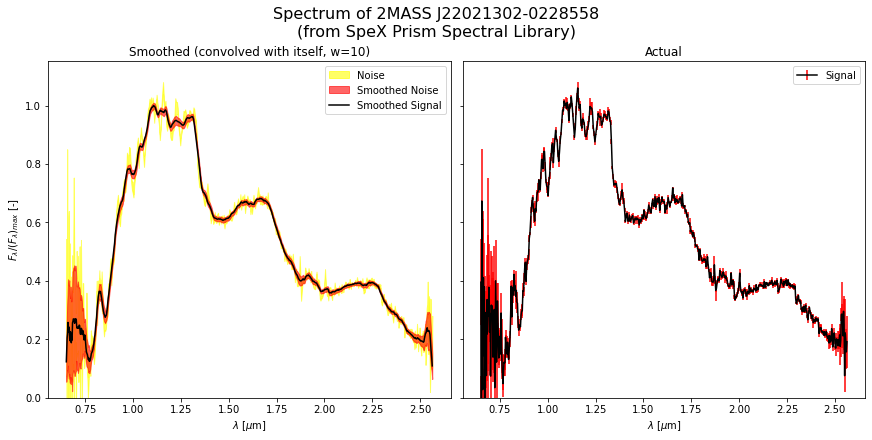

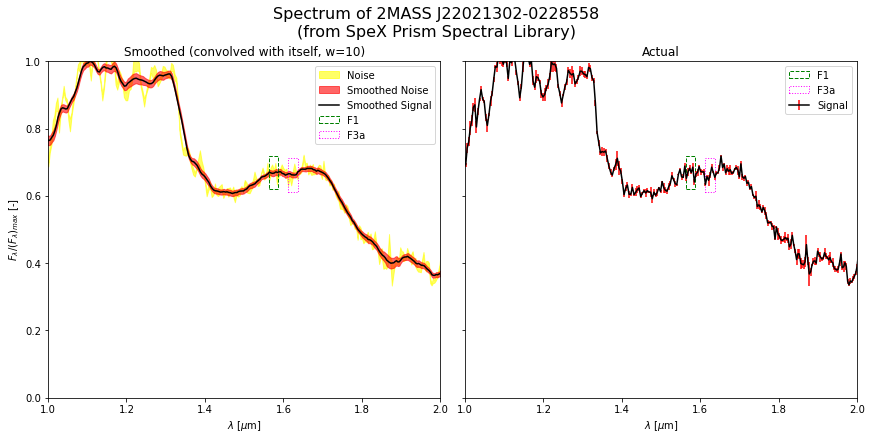

In [4]:
from astropy.io import ascii
import matplotlib as mpl

def conv_window(data, width):
    window = np.ones(width)/width
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

converters = {'col1': [ascii.convert_numpy(np.float64)],
              'col2': [ascii.convert_numpy(np.float64)],
              'col3': [ascii.convert_numpy(np.float64)]}
spec_star = ascii.read(".\spexprism_all\spex-prism_2MASSJ22021302-0228558_20050908_KIR10A.txt",
                      converters=converters)

fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                         constrained_layout=True,
                              sharey=True,
                         figsize=(12, 6))
ax.fill_between(spec_star['col1'],
                 spec_star['col2'] + spec_star['col3'],
                 spec_star['col2'] - spec_star['col3'],
                 alpha=0.6, color="yellow", label="Noise")
ax.fill_between(spec_star['col1'],
                 conv_window(spec_star['col2'] + spec_star['col3'], 10),
                 conv_window(spec_star['col2'] - spec_star['col3'], 10),
                 alpha=0.6, color="red", label="Smoothed Noise")
ax.plot(spec_star['col1'], conv_window(spec_star['col2'], 10), c="k", label="Smoothed Signal")
ax1.errorbar(spec_star['col1'], spec_star['col2'], spec_star['col3'], color="k", ecolor="red", label="Signal")

ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax1.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$F_{\lambda} / (F_{\lambda})_{max}$ [-]')
ax.set_title(r'Smoothed (convolved with itself, w=10)') 
ax1.set_title(r'Actual') 
ax.set_ylim(0., None)
ax1.set_ylim(0., None)
ax.legend()
ax1.legend()
fig.suptitle('Spectrum of 2MASS J22021302-0228558\n(from SpeX Prism Spectral Library)', fontsize=16)
plt.show()

# =========================================================

fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2,
                         constrained_layout=True,
                              sharey=True,
                         figsize=(12, 6))
ax.fill_between(spec_star['col1'],
                 spec_star['col2'] + spec_star['col3'],
                 spec_star['col2'] - spec_star['col3'],
                 alpha=0.6, color="yellow", label="Noise")
ax.fill_between(spec_star['col1'],
                 conv_window(spec_star['col2'] + spec_star['col3'], 10),
                 conv_window(spec_star['col2'] - spec_star['col3'], 10),
                 alpha=0.6, color="red", label="Smoothed Noise")
ax.plot(spec_star['col1'], conv_window(spec_star['col2'], 10), c="k", label="Smoothed Signal")
ax1.errorbar(spec_star['col1'], spec_star['col2'], spec_star['col3'], color="k", ecolor="red", label="Signal")

_f1 = 1.575 
_f3a = 1.625
_f1f = 0.669357
_f3af = 0.662178
_fw = 0.025
# 1.575 microns, and F3a is at 1.625 microns, with a full width of 0.025
p = mpl.patches.Rectangle((_f1 -  0.025 / 2, _f1f - 0.05), _fw, 0.1, fc="none", ec="g", ls="dashed", label="F1")
ax.add_artist(p)
p = mpl.patches.Rectangle((_f1 -  0.025 / 2, _f1f - 0.05), _fw, 0.1, fc="none", ec="g", ls="dashed", label="F1")
ax1.add_artist(p)

p = mpl.patches.Rectangle((_f3a -  0.025 / 2, _f3af - 0.05), _fw, 0.1, fc="none", ec="magenta", ls="dotted", label="F3a")
ax.add_artist(p)
p = mpl.patches.Rectangle((_f3a -  0.025 / 2, _f3af - 0.05), _fw, 0.1, fc="none", ec="magenta", ls="dotted", label="F3a")
ax1.add_artist(p)

ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax1.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$F_{\lambda} / (F_{\lambda})_{max}$ [-]')
ax.set_title(r'Smoothed (convolved with itself, w=10)') 
ax1.set_title(r'Actual') 
ax.set_ylim(0., 1.)
ax1.set_ylim(0., 1.)
ax.set_xlim(1., 2.)
ax1.set_xlim(1., 2.)
ax.legend()
ax1.legend()
fig.suptitle('Spectrum of 2MASS J22021302-0228558\n(from SpeX Prism Spectral Library)', fontsize=16)
plt.show()


---
<span style="  font-size:2em; color: SteelBlue;">Question 5.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Write a function `flux_filter(wlen, flux, wlen0, dwlen)` that calculates the mean flux transmitted through a boxcar filter with central wavelength `wlen0` and filter full width `dwlen`, and the spectrum is input as `(wlen, flux)`**

In [5]:
def flux_filter(wlen, flux, wlen0, dwlen):
    """flux_filter - returns the mean flux transmitted through a boxcar filter with central 
            wavelength wlen0, filter width dwlen and flux input is (wlen, flux)""" 
    # I weigh the flux depending on the window width of the sample
    # I expect ordered input:
    s_idxs = np.argsort(wlen)
    wlen = wlen[s_idxs]
    flux = flux[s_idxs]
    idxs = np.argwhere((wlen >= wlen0 - dwlen / 2) & (wlen <= wlen0 + dwlen / 2))
    weights = np.zeros(idxs.size + 3)
    weights[1:-2] = wlen[idxs].flatten()
    weights[0], weights[-2], weights[-1] = wlen[idxs[0] - 1], wlen[idxs[-1] + 1], wlen[idxs[-1] + 2]
    weights[1:] -= weights[:-1]
    weights[0] = weights[1]
    weights = np.mean(np.vstack((weights[0:-3],
                                 weights[1:-2],
                                 weights[2:-1])), axis=0) 
    weights *= 1/np.sum(weights)
    return np.average(flux[idxs].flatten(), weights=weights), np.mean(flux[idxs].flatten())

a = flux_filter(spec_star['col1'], spec_star['col2'], 1.575, 0.1)
print(f'I weigh the flux by the window width of the sample to not bias the result.\nUsing the mean would give us a biased flux:\n\tMean flux = {a[1]:.5f}\n\tAverage flux = {a[0]:.5f}\n\tRelative error = {np.abs(a[0]-a[1])/a[0]:.3e}\nIn this case the bias is samll.')

I weigh the flux by the window width of the sample to not bias the result.
Using the mean would give us a biased flux:
	Mean flux = 0.66225
	Average flux = 0.66223
	Relative error = 3.297e-05
In this case the bias is samll.


---
<span style="  font-size:2em; color: SteelBlue;">Question 5.3</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Calculate the MSI, `star_msi`, for this M8.5 star, and display it to 2 decimal places.**


In [6]:

mf1, __ = flux_filter(spec_star['col1'], spec_star['col2'], _f1, _fw)
mf3a, __ = flux_filter(spec_star['col1'], spec_star['col2'], _f3a, _fw)
star_msi =  mf1 / mf3a
print(f'Methane spectral index of the star is {star_msi:.2e}\n\t Mean flux in band F1:  {mf1:.2e},\n\t Mean flux in band F3a: {mf3a:.2e}')


Methane spectral index of the star is 1.01e+00
	 Mean flux in band F1:  6.67e-01,
	 Mean flux in band F3a: 6.59e-01


<a id='part2'></a>

## Determining the MSI of the secondary companion

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.4</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Measure the flux of the primary star and secondary companion using apertures with a diameter of 0.4 arcseconds.**

<div class="alert alert-block alert-info">
<b>Hint 1:</b> Calculate the diameter of the aperture in pixels and examine the image cubes in ds9. <br>Investigate the options of the Frame toolbar to switch between all the different images that are stored in the cube </div>

1. **Make two arrays - one holding the measured x position and one for the y positions of the primary star.** 
* **Use an offset to determine the position of the secondary companion with respect to the primary companion.**
* **Make a loop to go over each of the 4 images, and write out the flux ratio between the primary star and the secondary companion.**

<div class="alert alert-block alert-info">
<b>Hint 2:</b> Is the background flux surrounding the stars at a level of zero counts? <br>If not, you should measure the background flux and subtract it off the image...</div>

---


In [7]:
scale = 0.01725 # arcsec/pixel
d =  0.4 # arcsec
da = d / scale
ra = da / 2.
xmin, xmax = 140, 190
ymin, ymax = xmin, xmax

print(f'Aperture diameter: {da:.2f} px')
print(f'Aperture radius:   {ra:.2f} px')


# subtract background
# should also use sigma clipping here, but oh well...
# before I used the mean here, see the commented out version:
for i, img in enumerate(f1):
    f1[i] = img - np.median(img[xmin:xmax, ymin:ymax])

# clear hot pixel
for i, img in enumerate(f3a):
    f3a[i] = img - np.median(img[xmin:xmax, ymin:ymax])
    img[135:140, 27:32] = 0.
    
# if necessary you can compare this to the performance when using the median pixel values by (un)commenting the lines.
# xmin, xmax = 145, 155
# ymin, ymax = xmin, xmax
# for i, img in enumerate(f1):
#     f1[i] = img - np.mean(img[xmin:xmax, ymin:ymax])

# # clear hot pixel
# for i, img in enumerate(f3a):
#     f3a[i] = img - np.mean(img[xmin:xmax, ymin:ymax])
#     img[135:140, 27:32] = 0.
    

try:
    # since we have used it before
    from astropy.convolution import Gaussian2DKernel
    from astropy.convolution import convolve
    # not really needed but convienient
    from astropy.stats import sigma_clip
    
    def find_star_center(img, n=10):
        """
        Finds center of single brightest object in image
        Fist smoothes, then rejects outliers 
        returns average pixel position weighted by (smoothed) pixel flux as floats
        """
        
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        img_conv = convolve(img, kernel)
        ind = np.argpartition(img_conv, -n, axis=None)[-n:]
        ind = np.unravel_index(ind, img.shape)
        filtered_ind = sigma_clip(ind, sigma=5, maxiters=5,
                                  axis=1)
        center = np.average(filtered_ind,
                            weights = img[tuple(filtered_ind)] / np.sum(img[tuple(filtered_ind)]),
                            axis=1)
        return np.flip(center)

    xy_main_f1 = np.array([find_star_center(img) for img in f1])
    
    dxy_comp = np.array([63, 35]) - xy_main_f1[1]
    
    xy_comp_f1 = np.array([find_star_center(
        circle_mask(img,
                *(main_pos + dxy_comp),
                10) * img)
                           for img, main_pos in zip(f1, xy_main_f1)])
    
    xy_main_f3a = np.array([find_star_center(img) for img in f3a])
    
    xy_comp_f3a = np.array([find_star_center(
        circle_mask(img,
                *(main_pos + dxy_comp),
                10) * img)
                            for img, main_pos in zip(f3a, xy_main_f3a)])
    
except BaseException:    
    xy_main_f1 = np.array([
        [ 72.98173653, 111.22064106],
        [ 73.00838902,  99.81462311],
        [ 50.00555173,  99.8133108 ],
        [ 50.69337548, 122.70614343]]
    )
    
    dxy_comp = np.array([35, 63]) - xy_main_f1[1]
    
    xy_comp_f1 = np.array([
        [61.27581602, 45.68009898],
        [61.17416219, 33.50366289],
        [38.46326165, 33.7610906 ],
        [39.35530933, 56.36895451]]

    )  
    
    xy_main_f3a = np.array([
        [ 73.77086066, 114.02004448],
        [ 73.81008808, 102.5178966 ],
        [ 50.80052502, 102.51420242],
        [ 51.48901974, 125.79428897]]

    )  
    
    xy_comp_f3a = np.array([
        [63.5859387,  45.23725068],
        [61.99032658, 36.18350823],
        [39.14509938, 35.82669661],
        [38.52538182, 58.96028521]]

    )  

f_rat_f1 = np.zeros(len(f1))
f_rat_f3a = np.zeros(len(f3a))

flux_rad = ra
    
for i in range(len(f1)):
    f_rat_f1[i] = np.sum(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad) * f1[i]) \
    / np.sum(circle_mask(f1[i], *(xy_main_f1[i]), flux_rad) * f1[i])
    f_rat_f3a[i] = np.sum(circle_mask(f3a[i], *(xy_comp_f3a[i]), flux_rad) * f3a[i]) \
    / np.sum(circle_mask(f3a[i], *(xy_main_f3a[i]), flux_rad) * f3a[i])
    

print("\n")
print("Method using the summed flux of the stars:")

print(f"\tFlux ratio (F_comp / F_main) in F1 is:  {np.mean(f_rat_f1):.3e}")
print(f"\tFlux ratio (F_comp / F_main) in F3a is: {np.mean(f_rat_f3a):.3e}")

for i in range(len(f1)):
    print(f"\t\tImage {i}:\n \t\t\tF1_comp  / F1_main:  {f_rat_f1[i]:.3e}\n\t\t\tF3a_comp / F3a_main: {f_rat_f3a[i]:.3e}")

msi = (f_rat_f1 * mf1) / (f_rat_f3a * mf3a)

msi_mean = np.mean(msi)
msi_err = np.std(msi)
their_msi = msi
their_msi_mean = msi_mean
their_msi_err = msi_err

print('\tMethane spectral index of the companion is {:.2f} +- {:.2f}'.format(msi_mean, msi_err))

flux_rad = 2.5
    
for i in range(len(f1)):
    f_rat_f1[i] = np.mean(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad) * f1[i]) \
    / np.mean(circle_mask(f1[i], *(xy_main_f1[i]), flux_rad) * f1[i])
    f_rat_f3a[i] = np.mean(circle_mask(f3a[i], *(xy_comp_f3a[i]), flux_rad) * f3a[i]) \
    / np.mean(circle_mask(f3a[i], *(xy_main_f3a[i]), flux_rad) * f3a[i])
    
print("\n")
print("My method, using the mean center flux of the stars:")

print(f"\tFlux ratio (F_comp  / F_main) in F1 is: {np.mean(f_rat_f1):.3e}")
print(f"\tFlux ratio (F_comp / F_main) in F3a is: {np.mean(f_rat_f3a):.3e}")

for i in range(len(f1)):
    print(f"\t\tImage {i}:\n\t\t\tF1_comp / F1_main:   {f_rat_f1[i]:.3e}\n\t\t\tF3a_comp / F3a_main: {f_rat_f3a[i]:.3e}")

msi = (f_rat_f1 * mf1) / (f_rat_f3a * mf3a)

msi_mean = np.mean(msi)
msi_err = np.std(msi)
my_msi = msi
my_msi_mean = msi_mean
my_msi_err = msi_err

print('\tMethane spectral index of the companion is {:.2f} +- {:.2f}'.format(msi_mean, msi_err))

Aperture diameter: 23.19 px
Aperture radius:   11.59 px


Method using the summed flux of the stars:
	Flux ratio (F_comp / F_main) in F1 is:  4.287e-02
	Flux ratio (F_comp / F_main) in F3a is: 1.956e-02
		Image 0:
 			F1_comp  / F1_main:  4.186e-02
			F3a_comp / F3a_main: 1.589e-02
		Image 1:
 			F1_comp  / F1_main:  4.032e-02
			F3a_comp / F3a_main: 1.825e-02
		Image 2:
 			F1_comp  / F1_main:  4.400e-02
			F3a_comp / F3a_main: 2.146e-02
		Image 3:
 			F1_comp  / F1_main:  4.530e-02
			F3a_comp / F3a_main: 2.264e-02
	Methane spectral index of the companion is 2.25 +- 0.25


My method, using the mean center flux of the stars:
	Flux ratio (F_comp  / F_main) in F1 is: 3.525e-02
	Flux ratio (F_comp / F_main) in F3a is: 1.381e-02
		Image 0:
			F1_comp / F1_main:   3.567e-02
			F3a_comp / F3a_main: 9.398e-03
		Image 1:
			F1_comp / F1_main:   3.292e-02
			F3a_comp / F3a_main: 1.461e-02
		Image 2:
			F1_comp / F1_main:   3.359e-02
			F3a_comp / F3a_main: 1.468e-02
		Image 3:
			F1_comp / F1_

In retrospect I have to say that the result using mean flux is absolutely crazy close to what good ol' Biller et al. (2006) find.

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.5</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**SANITY CHECK on Question 5.4**

**Make sure you have got your coordinates right by cutting out a `box(x,y,30)` of the image and displaying it. The star/companion should be in the middle of the box. Have a look at the code below to make a 2x2 array of images, or simply make 4 images from the `F1` cube showing that you have the primary star location correct**

It should look something like:

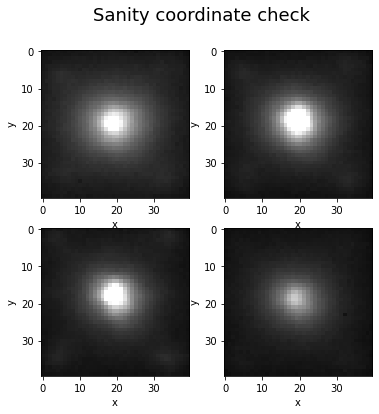

---


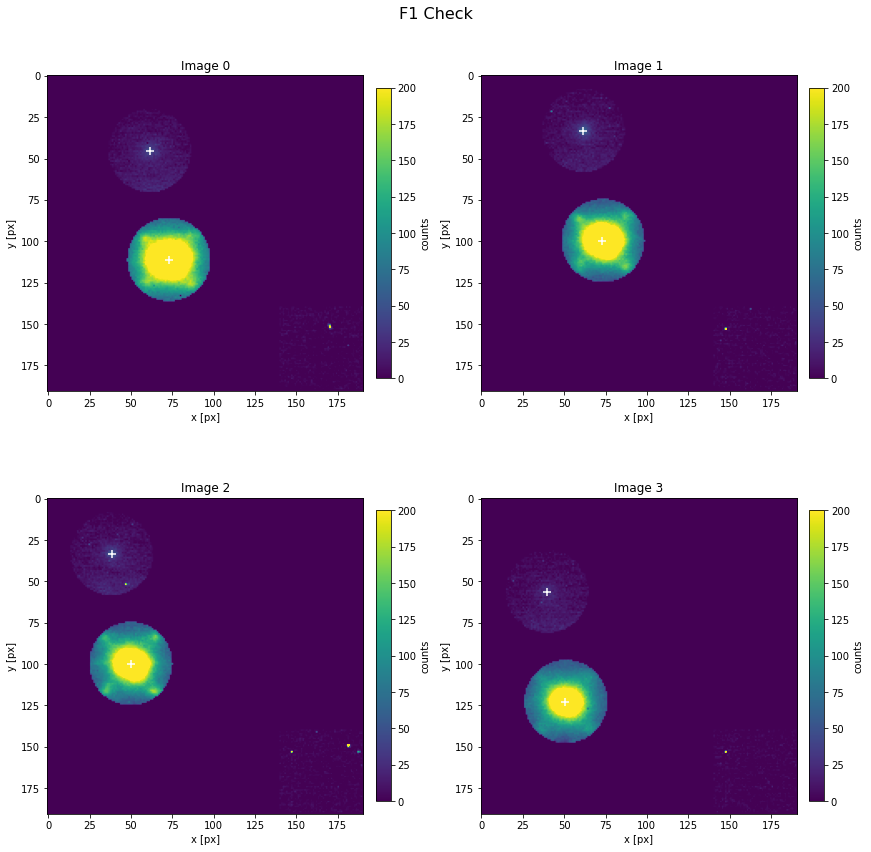

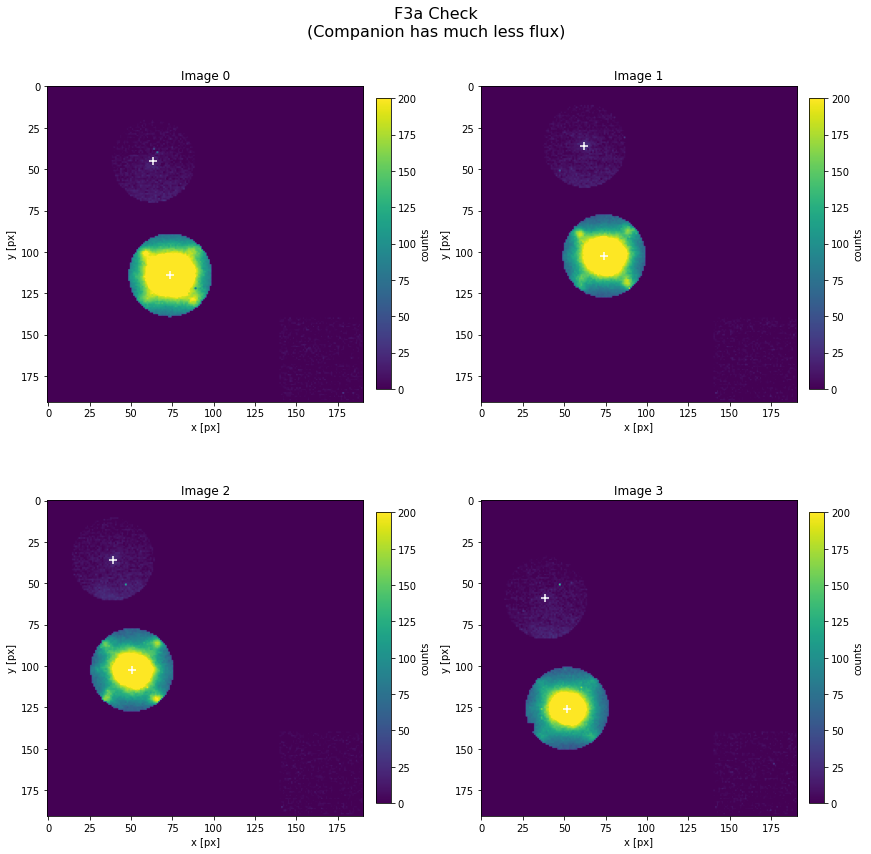

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2,
                         constrained_layout=True,
                         figsize=(12, 12))
for i, (img, ax) in enumerate(zip(f1, np.array(axes).flatten())):
    background = np.zeros_like(img) 
    background[xmin:xmax, ymin:ymax] = img[xmin:xmax, ymin:ymax]
    im = ax.imshow(
        circle_mask(img, *(xy_main_f1[i]), 25) * img + circle_mask(img, *(xy_comp_f1[i]), 25) * img + background,
        vmin=0., vmax=200.,
        )
    plt.colorbar(im, ax=ax, label="counts", fraction=0.046, pad=0.04)
    ax.scatter(*xy_main_f1[i], c="w", marker="+", s=50)
    ax.scatter(*xy_comp_f1[i], c="w", marker="+", s=50)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title(f'Image {i}') 
    
fig.suptitle(r'F1 Check', fontsize=16)
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2,
                         constrained_layout=True,
                         figsize=(12, 12))
for i, (img, ax) in enumerate(zip(f3a, np.array(axes).flatten())):
    background = np.zeros_like(img) 
    background[xmin:xmax, ymin:ymax] = img[xmin:xmax, ymin:ymax]
    im = ax.imshow(
        circle_mask(img, *(xy_main_f3a[i]), 25) * img + circle_mask(img, *(xy_comp_f3a[i]), 25) * img + background,
        vmin=0., vmax=200.,
        )
    plt.colorbar(im, ax=ax, label="counts", fraction=0.046, pad=0.04)
    ax.scatter(*xy_main_f3a[i], c="w", marker="+", s=50)
    ax.scatter(*xy_comp_f3a[i], c="w", marker="+", s=50)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title(f'Image {i}') 
    
fig.suptitle('F3a Check\n(Companion has much less flux)', fontsize=16)
plt.show()

# background field shown in the lower right corner

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Now you have 4 measurements of flux ratio at F1 and at F3a for the primary star compared to the secondary companion. Calculate the MSI for the secondary companion and estimate an error using `np.mean()` and `np.std()`. You should obtain one value for the MSI and one error.**


<div class="alert alert-block alert-info">
<b>Tip:</b> You can use your answer/findings from Question 5.4 </div>

---


Methane spectral index of the companion is 2.70 +- 0.66  when using mean stellar flux.


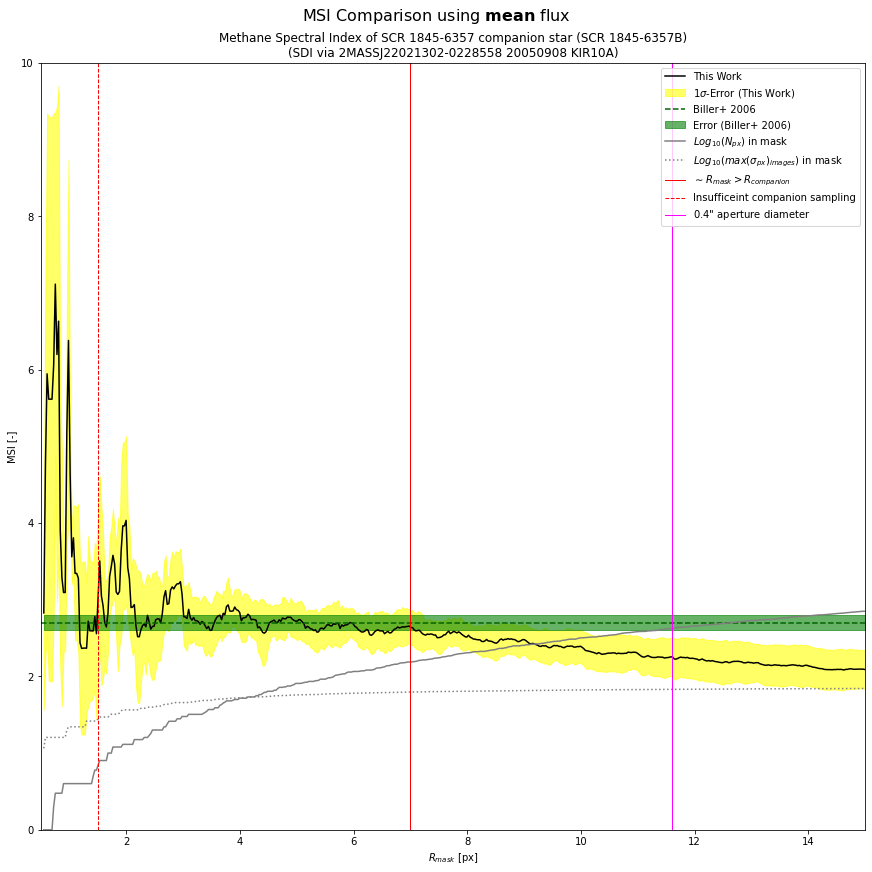

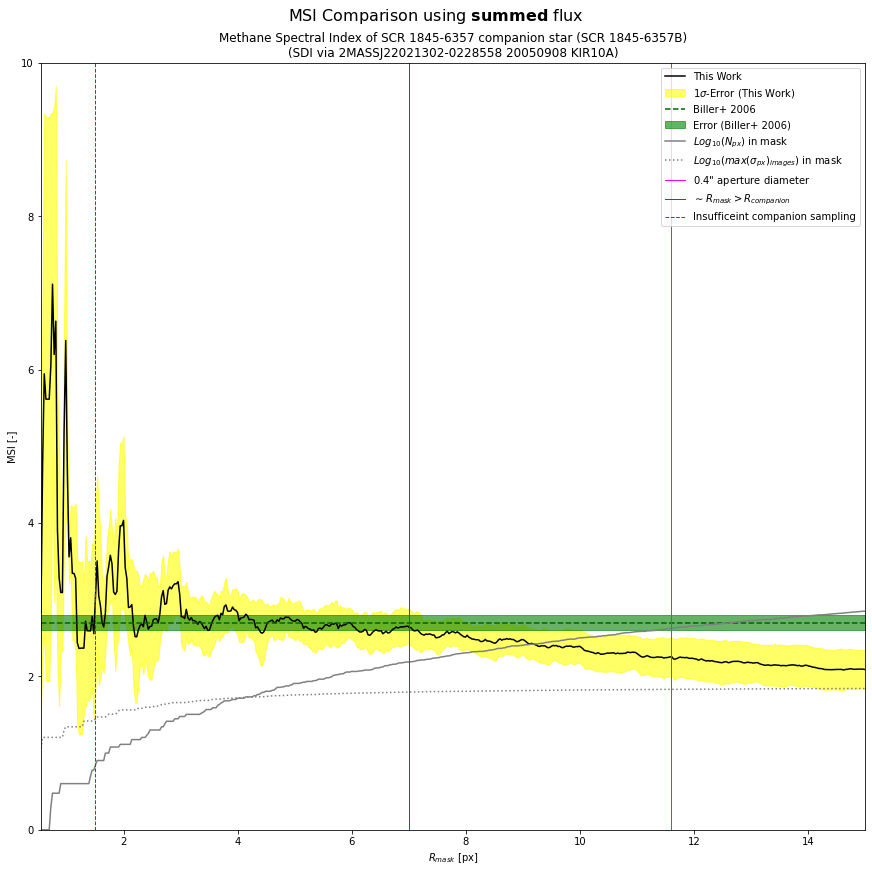

In [9]:
# Q6 answer here

msi = (f_rat_f1 * mf1) / (f_rat_f3a * mf3a)

# msi = msi[ :-1]

# Q6 end of answer


msi_mean = np.mean(msi)
msi_err = np.std(msi)

print('Methane spectral index of the companion is {:.2f} +- {:.2f}'.format(msi_mean, msi_err), " when using mean stellar flux.")

# Q6 extended

_f_rat_f1 = np.zeros(len(f1))
_f_rat_f3a = np.zeros(len(f3a))

flux_rads = np.linspace(0.55, 15., 500)
msi_means = np.zeros_like(flux_rads)
msi_errs = np.zeros_like(flux_rads)
n_pixs = np.zeros_like(flux_rads)
var_pixs = np.zeros_like(flux_rads)

for j, flux_rad in enumerate(flux_rads):
    n_pixs[j] = np.sum(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad))
    for i in range(len(f1)):
        _f_rat_f1[i] = np.mean(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad) * f1[i]) / np.mean(circle_mask(f1[i], *(xy_main_f1[i]), flux_rad) * f1[i])
        _f_rat_f3a[i] = np.mean(circle_mask(f3a[i], *(xy_comp_f3a[i]), flux_rad) * f3a[i]) / np.mean(circle_mask(f3a[i], *(xy_main_f3a[i]), flux_rad) * f3a[i])
        var_pixs[j] = np.max((var_pixs[j],
                              np.std(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad) * f1[i]),
                             np.std(circle_mask(f1[i], *(xy_main_f1[i]), flux_rad) * f1[i]),
                             np.std(circle_mask(f3a[i], *(xy_comp_f3a[i]), flux_rad) * f3a[i]),
                             np.std(circle_mask(f3a[i], *(xy_main_f3a[i]), flux_rad) * f3a[i])))

    msi = (_f_rat_f1 * mf1) / (_f_rat_f3a * mf3a)

    msi_means[j] = np.mean(msi)
    msi_errs[j] = np.std(msi)
    
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(flux_rads, msi_means, c="k", label="This Work")
ax.fill_between(flux_rads,
                 msi_means + msi_errs,
                 msi_means - msi_errs,
                 alpha=0.6, color="yellow", label=r"$1\sigma$-Error (This Work)")

ax.axhline(2.7, label="Biller+ 2006", c="darkgreen", ls="dashed")
ax.fill_between(flux_rads,
                 2.7 + 0.1, # no idea why it doesnt look right, I think its because I dont draw the bounding lines
                 2.7 - 0.1,
                 alpha=0.6, color="green", label="Error (Biller+ 2006)")

ax.plot(flux_rads, np.log10(n_pixs), c="gray", label=r"$Log_{10}(N_{px})$ in mask")
ax.plot(flux_rads, np.log10(var_pixs), c="gray", ls="dotted", label=r"$Log_{10}(max(\sigma_{px})_{images})$ in mask")

ax.axvline(7., label=r'$\sim R_{mask}>R_{companion}$', c="red", ls="solid", lw=1)
ax.axvline(1.5, label=r'Insufficeint companion sampling', c="red", ls="dashed", lw=1)
ax.axvline(ra, label=r'$0.4$" aperture diameter', c="magenta", ls="solid", lw=1)

ax.set_xlabel(r'$R_{mask}$ [px]')
ax.set_ylabel('MSI [-]')
ax.set_title(f'Methane Spectral Index of SCR 1845-6357 companion star (SCR 1845-6357B)\n(SDI via 2MASSJ22021302-0228558 20050908 KIR10A)') 

ax.set_xlim(0.5, 15.)
ax.set_ylim(0., 10.)

ax.legend()
    
fig.suptitle(r'MSI Comparison using $\mathbf{mean}$ flux', fontsize=16)
plt.show()


# Q6 extended extended because I didnt read the task properly (this time with summing flux)

_f_rat_f1 = np.zeros(len(f1))
_f_rat_f3a = np.zeros(len(f3a))

flux_rads = np.linspace(0.55, 15., 500)
msi_means = np.zeros_like(flux_rads)
msi_errs = np.zeros_like(flux_rads)
n_pixs = np.zeros_like(flux_rads)
var_pixs = np.zeros_like(flux_rads)

for j, flux_rad in enumerate(flux_rads):
    n_pixs[j] = np.sum(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad))
    for i in range(len(f1)):
        _f_rat_f1[i] = np.sum(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad) * f1[i]) / np.sum(circle_mask(f1[i], *(xy_main_f1[i]), flux_rad) * f1[i])
        _f_rat_f3a[i] = np.sum(circle_mask(f3a[i], *(xy_comp_f3a[i]), flux_rad) * f3a[i]) / np.sum(circle_mask(f3a[i], *(xy_main_f3a[i]), flux_rad) * f3a[i])
        var_pixs[j] = np.max((var_pixs[j],
                              np.std(circle_mask(f1[i], *(xy_comp_f1[i]), flux_rad) * f1[i]),
                             np.std(circle_mask(f1[i], *(xy_main_f1[i]), flux_rad) * f1[i]),
                             np.std(circle_mask(f3a[i], *(xy_comp_f3a[i]), flux_rad) * f3a[i]),
                             np.std(circle_mask(f3a[i], *(xy_main_f3a[i]), flux_rad) * f3a[i])))

    msi = (_f_rat_f1 * mf1) / (_f_rat_f3a * mf3a)

    msi_means[j] = np.mean(msi)
    msi_errs[j] = np.std(msi)
    
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(flux_rads, msi_means, c="k", label="This Work")
ax.fill_between(flux_rads,
                 msi_means + msi_errs,
                 msi_means - msi_errs,
                 alpha=0.6, color="yellow", label=r"$1\sigma$-Error (This Work)")

ax.axhline(2.7, label="Biller+ 2006", c="darkgreen", ls="dashed")
ax.fill_between(flux_rads,
                 2.7 + 0.1, # no idea why it doesnt look right, I think its because I dont draw the bounding lines
                 2.7 - 0.1,
                 alpha=0.6, color="green", label="Error (Biller+ 2006)")

ax.plot(flux_rads, np.log10(n_pixs), c="gray", label=r"$Log_{10}(N_{px})$ in mask")
ax.plot(flux_rads, np.log10(var_pixs), c="gray", ls="dotted", label=r"$Log_{10}(max(\sigma_{px})_{images})$ in mask")

ax.axvline(ra, label=r'$0.4$" aperture diameter', c="magenta", ls="solid", lw=1)
ax.axvline(7., label=r'$\sim R_{mask}>R_{companion}$', c="red", ls="solid", lw=1)
ax.axvline(1.5, label=r'Insufficeint companion sampling', c="red", ls="dashed", lw=1)

ax.set_xlabel(r'$R_{mask}$ [px]')
ax.set_ylabel('MSI [-]')
ax.set_title(f'Methane Spectral Index of SCR 1845-6357 companion star (SCR 1845-6357B)\n(SDI via 2MASSJ22021302-0228558 20050908 KIR10A)') 

ax.set_xlim(0.55, 15.)
ax.set_ylim(0., 10.)

ax.legend()
    
fig.suptitle(r'MSI Comparison using $\mathbf{summed}$ flux', fontsize=16)
plt.show()



## Comapring your result to Biller et al. (2006)
The measured methane spectral index in Biller et al. (2006) is $2.7 \pm 0.1$

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Is there a significant difference between your MSI and that in the paper? If YES, why? Are your propagated errors larger than Biller's measurements? If YES, why?**

---



Yes there is a difference, but their result is generally within my error bars. For small mask radii the stars are not sufficiently sampled and the result sufferes from a lot of noise (see the large 1 sigma confidence interval). This shows that the companion star is probably not sufficiently sampled and hence that the result can not be trusted left of the dashed red line. For large radii the signal of the companion star becomes smaller than the noise and the np.mean operation with wich I find the flux tends to underestimate the star flux (it samples regions without flux after all). Hence the region right of the solid red line is unusable as more and more flux from the main star is collected but less and less flux from the companion is within the aperture. The flux from the main star is also more "dispersed" when smoothed by the convolution I use to find the center, so that the center estimation might easier be off. Checking by hand however, it seems like there is little differnece to finding the center visually.
Furthermore, the star we use to get the spectrum from is different from the one used by Biller et al. (2006). In turn depending on the refernce star spectrum I might also get different values for the companion MSI. However the MSI of M8.5 stars should not vary super widely.

My error bars are also larger than Biller et al. (2006), they are mostly due to the variance in the image cubes, however the error from the spectrum of the refeence star also does contribute some part. The error and accuracy of my result strongly depends on the "goodness" of the background removal and generally the quality of the postprocessing. Give the whole notebook a try when you use the mean-based background removal in 5.4, its really a stark contrast and the arguments above weigh much more heavy on the selection of a good estimate for the MSI.

Biller et al. (2006) also differenced the images inside the cubes to remove the halo and speckles which are (maybe) in our images (they look quite clear actually so I am not sure sure if they have not been previously removed). Lastly, the images were median combined by Biller et al. (2006) further reducing the influence that noise or remaining speckles might have.

Also, while writing this I just realized that we were supposed to use a specific apperture size and sum the fluxes of over it, so I added that as a magenta line in the second plot above. This result also disagres with the result of Biller et al. (2006) and performs similar to the my method. With this method however, there is no argument to reject the MSI values that are probably not right (outside the red lines). On the contrary, we would suspect the values near large apertures to be more accurate as they give a better estimate for the total flux difference. Is that fair though? Since the stars have very different sizes (in the end we want to capture the temperature here) the result is off.

Id like to note that my method is very cool and produces a nice result for the range of values where it can be used. Sweet! (This judgement is in no way influenced by or based on sunken cost.)

Addendum, when I wrote all of the above I used the mean of part of the image to subtract the background, now I am using the median (it will become more clear below that I realized using the mean is a bad idea, due to the massive error bars). Well, it looks like my method is EVEN BETTER now, wuuuuuh! Seriously though, the curve follows Biller et al. (2006) for quite a a bit. Neat.

## Determining the spectral type of the secondary companion

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.8</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Construct a plot showing spectral type along the x-axis with methane spectral index on the y-axis.**

1. **Pick a star from every** ***Near IR spectral type*** **subtype from L6 to T8 (i.e. L6, L7, L8, L9, T0, T1...)**
2. **Calculate the Methane Spectral Index, and plot it below.**

<div class="alert alert-block alert-info">
<b>Tip:</b> It is easier to have a number represent the spectra type, i.e. 6 = L6, 8 = L8, 10 = T0....). </div>


3. **Overplot your measured Methane Spectral Index for the secondary companion and determine what spectral type the companion is.**
4. **Add legend, axis lables, etc.**
5. **Take the errors from your 4 measurements of MSI to estimate by eye an error in spectral type.**


---


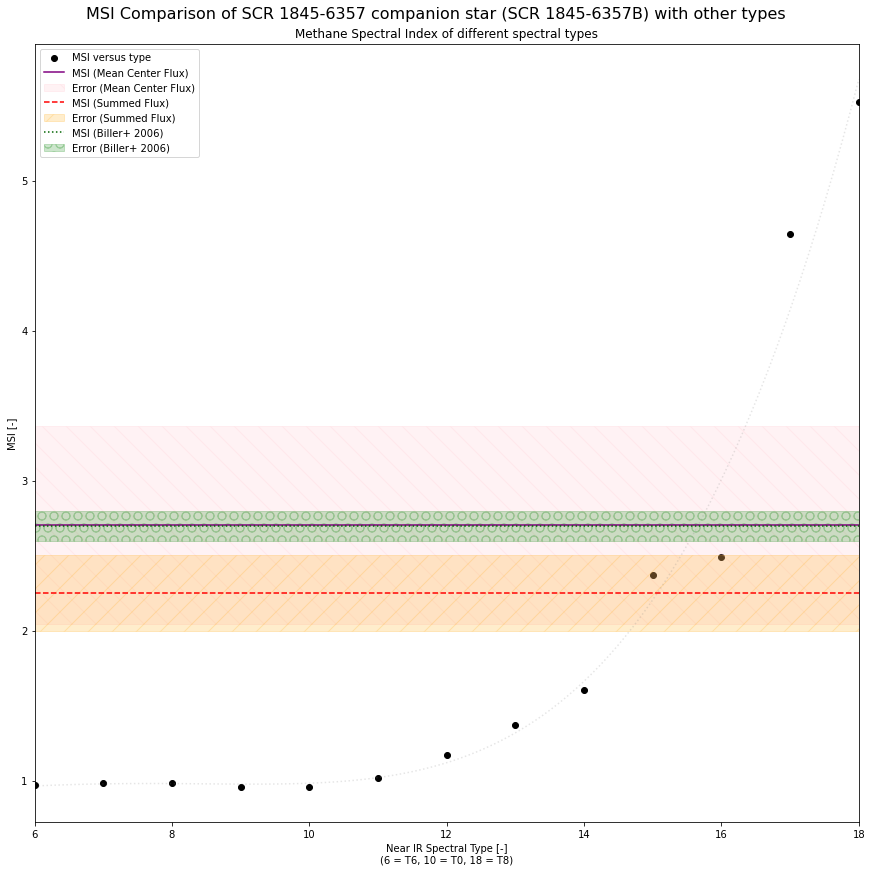

In [10]:
# Q8 answer here

files = np.array([
    'spex-prism_2MASSJ22120703+3430351_20080712_BUR10A.txt',
    'spex-prism_2MASSJ01414839-1601196_20051018_KIR10A.txt',
    'spex-prism_2MASSWJ1632291+190441_20030522_BUR04B.txt',
    'spex-prism_DENIS-PJ0255-4700_20040908_BUR06C.txt',
    'spex-prism_Gl337CD_20060408_BUR10A.txt',
    'spex-prism_SDSSJ085834.42+325627.7_20050123_CHI06A.txt',
    'spex-prism_2MASSJ09490860-1545485_20040310_BUR06C.txt',
    'spex-prism_2MASSJ12095613-1004008_20030522_BUR04B.txt',
    'spex-prism_2MASSIJ2254188+312349_20030918_BUR04B.txt',
    'spex-prism_2MASSIJ0755480+221218_20040310_BUR06C.txt',
    'spex-prism_2MASSIJ0243137-245329_20030917_BUR04B.txt',
    'spex-prism_2MASSIJ0727182+171001_20040310_BUR06D.txt',
    'spex-prism_2MASSJ09393548-2448279_20040310_BUR06C.txt',
]) # please end the suffering, this was absolutely horrible

star_msis = np.zeros(len(files))
types = np.arange(6, 19)

for i, file in enumerate(files):
    spec_star = ascii.read('.\spexprism_all\\' + file,
                          converters=converters)
    # dat = spec_star.meta['comments']
    mf1, __ = flux_filter(spec_star['col1'], spec_star['col2'], _f1, _fw)
    mf3a, __ = flux_filter(spec_star['col1'], spec_star['col2'], _f3a, _fw)
    star_msis[i] =  mf1 / mf3a
    
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.scatter(types, star_msis, c="k", label="MSI versus type")
try:
    p = np.poly1d(np.polyfit(types, star_msis, 4))
    _types = np.linspace(6., 18., 100)
    _star_msis = p(_types)
    
except BaseException:
    _types = types
    _star_msis = star_msis
finally: 
    ax.plot(_types, _star_msis, c="gray", ls="dotted", alpha=0.2)


ax.axhline(my_msi_mean, label="MSI (Mean Center Flux)", c="purple", ls="solid")
ax.fill_between(types,
                 my_msi_mean + my_msi_err,
                 my_msi_mean - my_msi_err,
                 alpha=0.2, color="pink", label="Error (Mean Center Flux)",
                hatch="\\")


ax.axhline(their_msi_mean, label="MSI (Summed Flux)", c="red", ls="dashed")
ax.fill_between(types,
                 their_msi_mean + their_msi_err,
                 their_msi_mean - their_msi_err,
                 alpha=0.2, color="orange", label="Error (Summed Flux)",
               hatch="/")


ax.axhline(2.7, label="MSI (Biller+ 2006)", c="darkgreen", ls="dotted")
ax.fill_between(types,
                 2.7 + 0.1,
                 2.7 - 0.1,
                 alpha=0.2, color="green", label="Error (Biller+ 2006)",
               hatch="O")


ax.set_xlabel('Near IR Spectral Type [-]\n(6 = T6, 10 = T0, 18 = T8)')
ax.set_ylabel('MSI [-]')
ax.set_title(f'Methane Spectral Index of different spectral types') 

ax.legend()
ax.set_xlim(6, 18)
    
fig.suptitle(r'MSI Comparison of SCR 1845-6357 companion star (SCR 1845-6357B) with other types', fontsize=16)
plt.show()


# Q8 end of answer

Even if the MSI stars I have chosen have a small error it is not possibe to say wth vertainty what spectral type the companion is due to the large error bars (remember that they are 1 sigma in the plot!). Juding with ~2-3 sigma certainty the spectral type is above T2 and below T7. Since my method better estimated the MSI before I would suggest that the type is either T5 or T6 which seems to agree with the estimate of Biller+ 2006 which found a type of T5.5+/-1.  This estimate has a larger confidence interval than the one shown in the plot above which is also (presumably) 1 sigma.
The method summing the flux comes (barely) to a similar result. However, due to the issues with it explained above, it again underestimates the spectral type like it does the MSI.

Honestly, no idea why my error bars are so massive, especially for the method using summed flux since its very straight forward and should be quite insensitive to the aperture position since most flux is near the center. I also dont vary the center after finding it so it must be the varience between the different images themselves. Maybe I am doing the background subtraction wrong? As of writing I am only using the mean of a 100 pixels. I will see if using the median and more pixels will help. Ok, future me is back, I increased the window I use to get the background and use the median now, and I just can say wow! No comparison! Still Im sure the error bars can be decreased further (probably quite easily) by cleaning up the image in a smart way (i.e. remove the lobes etc. that are still visible).

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.99</span> <span style="  font-size:1em; color: SteelBlue;">
(0 points): </span>

**During coding I always find it nice to have some music playing in the background. What is your favourite song that you can recommend? Please put in artist/song and/or a youtube link**


---

In [11]:
# great stuff: Polyphia - G.O.A.T.
# https://www.youtube.com/watch?v=9_gkpYORQLU 
# but maybe this is even more crazy if you play guitar or like Flamenco:
# https://www.youtube.com/watch?v=UgqmxsxXnC0
# 0 points though :'( not even 0.01 points?


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it!</div>


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [12]:
# Number of hours taken for this practicum:
# 6 to 8 hours probably
# was fun but searching for the right spectral types was just horrible